# Nifti To Dicom

In this notebook, I'll be learning about the Dicom image format and converting my prostate nifti images into dicom to test the functionality of my integration.

In [6]:
import pydicom
import SimpleITK as sitk
import numpy as np
import nibabel as nib

In [7]:
test_nifti = nib.load('test_img_1.nii.gz')

In [10]:
test_nifti.header.get_zooms()

(1.0, 1.0, 0.999999)

In [2]:
test_dicom = sitk.ReadImage('test_img_1.nii.gz')

sitk.WriteImage(test_dicom[:, :, 1], 'test_dicom.dcm')

In [3]:
test_dicom.GetDepth()

80

In [5]:
test_dicom.GetSpacing()

(1.0, 1.0, 0.9999989867210388)

In [4]:
test_dicom.GetSize()

(180, 180, 80)

In [17]:
img_slice = pydicom.dcmread('test_dicom.dcm').pixel_array
img_slice.shape

(180, 180)

In [26]:
temp_dir = 'temp/'
for layer in range(test_dicom.GetDepth()):
    sitk.WriteImage(test_dicom[:, :, layer], temp_dir + 'test_dicom_' + str(layer) + '.dcm')

In [30]:
backtonifti = sitk.ReadImage('backtonifti.nii.gz')

In [31]:
backtonifti.GetSize()

(180, 180, 1)

In [14]:
import sys, time, os

def writeSlices(series_tag_values, new_img, i):
    image_slice = new_img[:,:,i]

    # Tags shared by the series.
    list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0], tag_value[1]), series_tag_values))

    # Slice specific tags.
    image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
    image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time

    # Setting the type to CT preserves the slice location.
    image_slice.SetMetaData("0008|0060", "CT")  # set the type to CT so the thickness is carried over

    # (0020, 0032) image position patient determines the 3D spacing between slices.
    image_slice.SetMetaData("0020|0032", '\\'.join(map(str,new_img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
    image_slice.SetMetaData("0020,0013", str(i)) # Instance Number

    # Write to the output directory and add the extension dcm, to force writing in DICOM format.
    writer.SetFileName('temp/' + str(i) + '.dcm')
    writer.Execute(image_slice)

def createSeries(nifti_file, save_dir):
    # Create a new series from a numpy array
    new_img = sitk.ReadImage('test_img_1.nii.gz')
    new_img.SetSpacing(new_img.GetSpacing())

    # Write the 3D image as a series
    # IMPORTANT: There are many DICOM tags that need to be updated when you modify an
    #            original image. This is a delicate opration and requires knowlege of
    #            the DICOM standard. This example only modifies some. For a more complete
    #            list of tags that need to be modified see:
    #                           http://gdcm.sourceforge.net/wiki/index.php/Writing_DICOM
    #            If it is critical for your work to generate valid DICOM files,
    #            It is recommended to use David Clunie's Dicom3tools to validate the files 
    #                           (http://www.dclunie.com/dicom3tools.html).

    writer = sitk.ImageFileWriter()
    # Use the study/series/frame of reference information given in the meta-data
    # dictionary and not the automatically generated information from the file IO
    writer.KeepOriginalImageUIDOn()

    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    # Copy some of the tags and add the relevant tags indicating the change.
    # For the series instance UID (0020|000e), each of the components is a number, cannot start
    # with zero, and separated by a '.' We create a unique series ID using the date and time.
    # tags of interest:
    direction = new_img.GetDirection()
    series_tag_values = [("0008|0031",modification_time), # Series Time
                      ("0008|0021",modification_date), # Series Date
                      ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                      ("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time), # Series Instance UID
                      ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                        direction[1],direction[4],direction[7])))),
                      ("0008|103e", "Created-SimpleITK")] # Series Description

    # Write slices to output directory
    list(map(lambda i: writeSlices(series_tag_values, new_img, i), range(new_img.GetDepth())))

#     # Re-read the series
#     # Read the original series. First obtain the series file names using the
#     # image series reader.
#     data_directory = 'temp/'
#     series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(data_directory)
#     if not series_IDs:
#         print("ERROR: given directory \""+data_directory+"\" does not contain a DICOM series.")
#         sys.exit(1)
#     series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(data_directory, series_IDs[0])

#     series_reader = sitk.ImageSeriesReader()
#     series_reader.SetFileNames(series_file_names)

#     # Configure the reader to load all of the DICOM tags (public+private):
#     # By default tags are not loaded (saves time).
#     # By default if tags are loaded, the private tags are not loaded.
#     # We explicitly configure the reader to load tags, including the
#     # private ones.
#     series_reader.LoadPrivateTagsOn()
#     image3D = series_reader.Execute()

(1.0, 1.0, 0.999998986721039) vs (1.0, 1.0, 0.9999989867210388)


In [15]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames('temp/')
print(dicom_names)
reader.SetFileNames(dicom_names)
image = reader.Execute()
sitk.WriteImage(image, 'backtonifti.nii.gz')

('temp/0.dcm', 'temp/1.dcm', 'temp/2.dcm', 'temp/3.dcm', 'temp/4.dcm', 'temp/5.dcm', 'temp/6.dcm', 'temp/7.dcm', 'temp/8.dcm', 'temp/9.dcm', 'temp/10.dcm', 'temp/11.dcm', 'temp/12.dcm', 'temp/13.dcm', 'temp/14.dcm', 'temp/15.dcm', 'temp/16.dcm', 'temp/17.dcm', 'temp/18.dcm', 'temp/19.dcm', 'temp/20.dcm', 'temp/21.dcm', 'temp/22.dcm', 'temp/23.dcm', 'temp/24.dcm', 'temp/25.dcm', 'temp/26.dcm', 'temp/27.dcm', 'temp/28.dcm', 'temp/29.dcm', 'temp/30.dcm', 'temp/31.dcm', 'temp/32.dcm', 'temp/33.dcm', 'temp/34.dcm', 'temp/35.dcm', 'temp/36.dcm', 'temp/37.dcm', 'temp/38.dcm', 'temp/39.dcm', 'temp/40.dcm', 'temp/41.dcm', 'temp/42.dcm', 'temp/43.dcm', 'temp/44.dcm', 'temp/45.dcm', 'temp/46.dcm', 'temp/47.dcm', 'temp/48.dcm', 'temp/49.dcm', 'temp/50.dcm', 'temp/51.dcm', 'temp/52.dcm', 'temp/53.dcm', 'temp/54.dcm', 'temp/55.dcm', 'temp/56.dcm', 'temp/57.dcm', 'temp/58.dcm', 'temp/59.dcm', 'temp/60.dcm', 'temp/61.dcm', 'temp/62.dcm', 'temp/63.dcm', 'temp/64.dcm', 'temp/65.dcm', 'temp/66.dcm', 'tem

In [29]:
image

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f544d62dae0> >

In [17]:
image.GetSize()

(180, 180, 80)

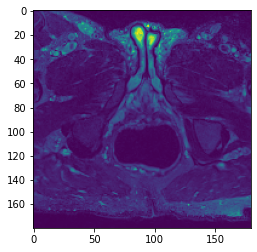

In [20]:
import matplotlib.pyplot as plt
plt.imshow(sitk.GetArrayFromImage(image)[10,:,:])

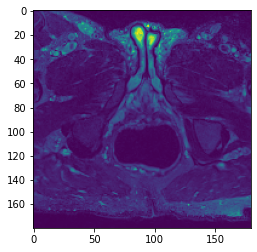

In [21]:
plt.imshow(sitk.GetArrayFromImage(test_dicom)[10,:,:])

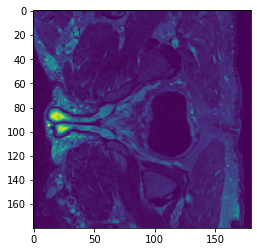

In [28]:
plt.imshow(nib.load('backtonifti.nii.gz').get_fdata()[:, :, 10])

In [46]:
import monai
from monai.transforms import (
    Compose,
    LoadNifti,
    NormalizeIntensity,
    AddChannel,
    ToTensor,
)

reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames('temp/')
print(dicom_names)
reader.SetFileNames(dicom_names)
image = reader.Execute()
sitk.WriteImage(image, 'temp/temp.nii.gz')

test_dataset = monai.data.NiftiDataset(
    image_files=['temp/temp.nii.gz'],
    transform=Compose(
        [
            AddChannel(),
            NormalizeIntensity(),
            ToTensor()
        ]
    )
)

('temp/0.dcm', 'temp/1.dcm', 'temp/2.dcm', 'temp/3.dcm', 'temp/4.dcm', 'temp/5.dcm', 'temp/6.dcm', 'temp/7.dcm', 'temp/8.dcm', 'temp/9.dcm', 'temp/10.dcm', 'temp/11.dcm', 'temp/12.dcm', 'temp/13.dcm', 'temp/14.dcm', 'temp/15.dcm', 'temp/16.dcm', 'temp/17.dcm', 'temp/18.dcm', 'temp/19.dcm', 'temp/20.dcm', 'temp/21.dcm', 'temp/22.dcm', 'temp/23.dcm', 'temp/24.dcm', 'temp/25.dcm', 'temp/26.dcm', 'temp/27.dcm', 'temp/28.dcm', 'temp/29.dcm', 'temp/30.dcm', 'temp/31.dcm', 'temp/32.dcm', 'temp/33.dcm', 'temp/34.dcm', 'temp/35.dcm', 'temp/36.dcm', 'temp/37.dcm', 'temp/38.dcm', 'temp/39.dcm', 'temp/40.dcm', 'temp/41.dcm', 'temp/42.dcm', 'temp/43.dcm', 'temp/44.dcm', 'temp/45.dcm', 'temp/46.dcm', 'temp/47.dcm', 'temp/48.dcm', 'temp/49.dcm', 'temp/50.dcm', 'temp/51.dcm', 'temp/52.dcm', 'temp/53.dcm', 'temp/54.dcm', 'temp/55.dcm', 'temp/56.dcm', 'temp/57.dcm', 'temp/58.dcm', 'temp/59.dcm', 'temp/60.dcm', 'temp/61.dcm', 'temp/62.dcm', 'temp/63.dcm', 'temp/64.dcm', 'temp/65.dcm', 'temp/66.dcm', 'tem